In this baseline python notebook, we loaded the dataset from Kaggle and attempted training with 
a. a 2 layer convnet with one fully connected layer
b. a 4 layer convnet with one fully connected layer
c. a 2 layer convnet with two fully connected layers.

We also performed data augmentation by flipping the images horizontally to increase the size of the training data

In [25]:
# Reference-https://www.tensorflow.org/get_started/mnist/pros

# Loading required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
import scipy.signal



# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

np.random.seed(0)


In [3]:
#flips images horizontally
def flip_images(inputdata):
    data=inputdata.copy()
    origcols = list(data.columns)
    newcols = [item for item in origcols]
    
    for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: -x)
    #print data.head()
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    
    for (a,b) in flip_indices:
        newcols[a],newcols[b] = newcols[b],newcols[a]

    colmap = {}
    for i in range(len(newcols)):
        colmap[origcols[i]]=newcols[i]
    
    data = data[newcols]
    data.rename(columns = colmap,inplace=True)
    #print data.head()

    
    data["Image"] = data["Image"].apply(lambda x: np.fliplr(x.reshape((96,96))).flatten())

    return data


In [4]:
# Create iterator to deliver data & labels in sets of batchSize
def imgs_iterator(data,labels,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
            batchIndices = indices[i:i+batchSize]
            yield np.stack(data[batchIndices]),labels[batchIndices],len(batchIndices)

# Same as imgs_iterator but for test data (don't return labels)
def imgs_iterator_predict(data,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
        batchIndices = indices[i:i+batchSize]
        
        yield np.stack(data[batchIndices]),len(batchIndices)

# Make predictions according to formula "y = Wx + b" for data set 
# Similar in form to training loop
def make_predictions(data,batch_size):
    results = data.copy()
    predictions_mb=[]
    # Iterate by batch size
    iter_test = imgs_iterator_predict(data,batch_size)
    try:
        next_batch =iter_test.__next__()
        while next_batch!=None:
            
            # Load next batch
            mini_batch,batch_size = next_batch
            
            # Reshape
            mini_batch = np.reshape(mini_batch,(batch_size,9216))
            
            # Make prediction with input data and dropout 
            feed_dict = {x: np.stack(mini_batch), keep_prob: 1.0}
            predictions = y.eval(feed_dict)
            predictions_mb.append(predictions)
            
            next_batch =iter_test.__next__()
    except StopIteration:
        next_batch=None
    results = pd.DataFrame(np.vstack(predictions_mb))
    
    return results

# Generate reports for submission
def generate_results(result):
    submission = pd.read_csv('/home/ubuntu/FacialKeypoints/data/SampleSubmission.csv')
    IdLookup = pd.read_csv('/home/ubuntu/FacialKeypoints/data/IdLookupTable.csv')
    IdLookupDict = IdLookup.set_index('RowId').T.to_dict('list')

    
    
    result.columns = dev.columns[0:30]
    output = pd.concat([test["ImageId"],result_test],axis=1)
    
    RowId = np.asarray(submission["RowId"],dtype=int)
    for row in RowId:
        r = IdLookupDict[row][0]-1
        c =IdLookupDict[row][1]
        submission.loc[row-1,"Location"]= max(0,min(96,(output.loc[r,c]*48+48)))
    
    
    submission.to_csv("submission.csv",index=False)


In [5]:
# Loading the test and raw training datasets
# Raw is 7049X31.  7049 training examples, 30 columns of facial feature x &y locations, 1 column for list of image pixel values
# Test is 1783X2. 1783 test examples, 1 column for image id, 1 column for list of image pixel values
raw = pd.read_csv('/home/ubuntu/FacialKeypoints/data/training.csv')
test = pd.read_csv('/home/ubuntu/FacialKeypoints/data/test.csv')


# Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)

for col in raw.columns.get_level_values(0)[0:30]:
    raw[col] = raw[col].apply(lambda x: (x-48)/48)
    
    




In [6]:
# Dropping training & test cases with na values since they will prevent the model from training correctly.
# Possibly revisit this to come up with a better approach
raw.dropna(inplace=True)
test.dropna(inplace=True)


# After removing the cases with 'na', re-shuffle (the training set) and re-do indexing
raw = raw.sample(frac=1) 
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [7]:
#Augment the dataset by adding flipped images
raw = pd.concat([raw,flip_images(raw)],axis=0)
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)

In [8]:
# Our training data set has 2140 examples at this point.  
# Allocate 80% for training and 20% for development.
train_size = int(raw.shape[0]*.8)
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]

# Re-index
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

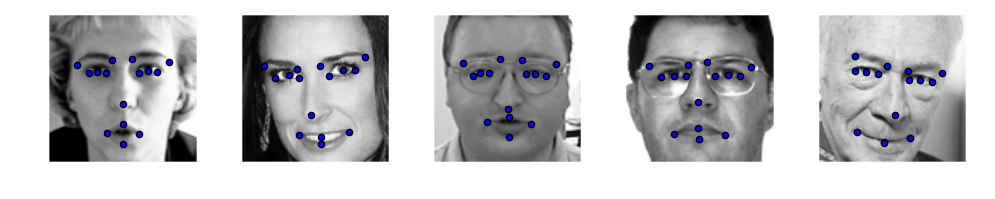

In [9]:
# Visualize 5 example images:
def plot_images(num_images,inputdata, inputresult=None,training=True):
    data=inputdata.copy()
    if inputresult is not None:
        result = inputresult.copy()
    plt.figure(figsize=(12,4))
    
    for col in data.columns.get_level_values(0)[0:30]:
            data[col] = data[col].apply(lambda x: x*48+48)
    
    if training==False:
        for col in result.columns.get_level_values(0)[0:30]:
            result[col] = result[col].apply(lambda x: x*48+48)
    
    
    for i in range(num_images):
        
        # Every example has 30 facial features and 1 column with a 9216-length list of pixel values of image
        # take the 9216 list of pixels and reshape into 96X96 image for viewing
        img =  np.reshape(data.ix[i:i,"Image"].values[0],(96,96))
        plt.subplot(1,num_images,i+1)
        plt.axis('off')
        
        # Show the facial image
        plt.imshow(img,cmap='Greys_r')
        
        
    

        # Get x & y values for the facial keypoints and overlay on the face
        x_values = np.asarray(data[data.columns.get_level_values(0)[0:30:2]])
        y_values = np.asarray(data[data.columns.get_level_values(0)[1:30:2]])
        plt.scatter(x_values[i],y_values[i])
        
        # If we are not using training data, then show our predicted facial keypoints with red x's
        if training==False:
            
        
            
            rx_values = np.asarray(result[result.columns.get_level_values(0)[0:30:2]])
            ry_values = np.asarray(result[result.columns.get_level_values(0)[1:30:2]])
            plt.scatter(rx_values[i],ry_values[i],marker="x",color='r')
            

plot_images(5,train)

In [10]:

# Convert the pixel arrays and facial feature locations in train/dev/test into numpy-array representation
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

test_data = test["Image"].as_matrix()

**Model1**

In the section below, an initial baseline model has been created with 2 conv+relu+maxpool layers and one fully connected layer

Running the model without dropout resulted in overfitting. Through crossvalidation , a dropout value of .25 was chosen to ensure generalization. 

The RMSE of this model using the test dataset was 4.48 on the Kaggle leaderboard

In [14]:
# Try 2-convolutional-layers, 1 fully connected

mini_batch_size=400
epochs = 300

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')



# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])


# Weights will be 4D tensor of size 5x5x1x32 from truncated normal, 32-length array bias of constant 0.1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


# x_image is in shape [batch, in_height, in_width, in_channels] ~ [-1, 96, 96, 1]
# W_conv1 is in shape [filter_height, filter_width, in_channels, out_channels] ~ [5,5,1,32]
# conv2d flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels]
#      ~ [5*5*1, 32] ~ [25, 32]
# Apply rectifier relu function
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# Perform reduction.  h_conv1 is [?,96,96,32] with strides [1,2,2,1]
# Returns a 48*48 image with 32 filters
h_pool1 = max_pool_2x2(h_conv1)

# 2nd convolutional layer - will return 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# Flatten resulting image to apply relu activation
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])

# Fully connected layer
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Apply dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Determine prediction function "y=Wx+b"
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss function, try minimize with AdamOptimizer (more efficient than gradient descent)
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


with tf.Session() as sess:
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in increments of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape 
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Determine accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.25})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))
        
    
        # Measure accuracy with trained NN on dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)

        # Get batch of 20 from dev data
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch

        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))

        # Calculate accuracy
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
    
    

    # Generate predictions for display
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    sess.close()


RMSE for Epoch 0 =0.381494
RMSE for dev set =0.374008
RMSE for Epoch 1 =0.281228
RMSE for dev set =0.265926
RMSE for Epoch 2 =0.220153
RMSE for dev set =0.193069
RMSE for Epoch 3 =0.156225
RMSE for dev set =0.1527
RMSE for Epoch 4 =0.152864
RMSE for dev set =0.149178
RMSE for Epoch 5 =0.113015
RMSE for dev set =0.111796
RMSE for Epoch 6 =0.112118
RMSE for dev set =0.115262
RMSE for Epoch 7 =0.0984867
RMSE for dev set =0.0874716
RMSE for Epoch 8 =0.0952514
RMSE for dev set =0.0915904
RMSE for Epoch 9 =0.0969576
RMSE for dev set =0.101154
RMSE for Epoch 10 =0.0788104
RMSE for dev set =0.0798094
RMSE for Epoch 11 =0.0915685
RMSE for dev set =0.0853692
RMSE for Epoch 12 =0.0769856
RMSE for dev set =0.0823491
RMSE for Epoch 13 =0.0877218
RMSE for dev set =0.0802315
RMSE for Epoch 14 =0.0699216
RMSE for dev set =0.0705485
RMSE for Epoch 15 =0.0808147
RMSE for dev set =0.0861209
RMSE for Epoch 16 =0.0756617
RMSE for dev set =0.0732421
RMSE for Epoch 17 =0.0710952
RMSE for dev set =0.0764828
R

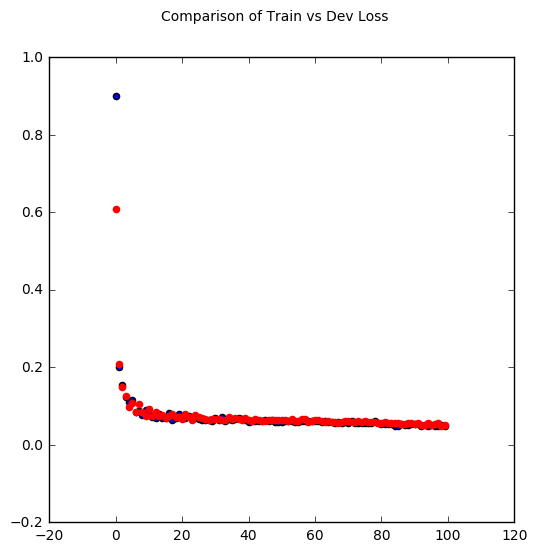

In [21]:

# Plot train/dev errors by epoch

plt.figure(figsize=(6,6))
plt.suptitle("Comparison of Training vs Dev Loss")
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


Based on the plots for training loss(blue) vs the test loss(red), we can conclude that our model does not overfit the data. However, there may be an opportunity to reduce the model's bias by adding additional layers.

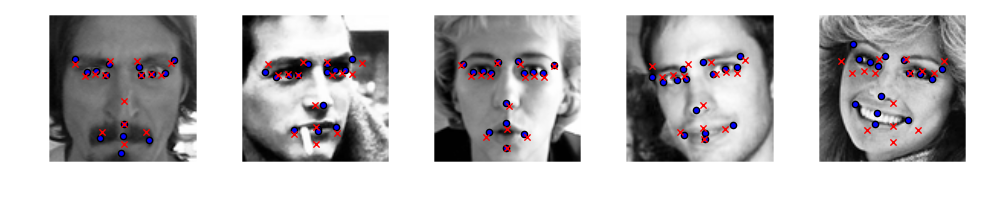

In [16]:
# Plot our predictions
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)
#

In [28]:
# Submission
generate_results(result_test)

**Model 2**
In an attempt to reduce the previous model's bias, 2 additional convolutional layers were added.

In [22]:
# Try 4 convolutional layers, 1 fully connected

mini_batch_size=400
epochs = 100

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Same as previous exercise, next return a 12*12 image with 128 filters
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Fourth convolutional layer, returns a 6*6 image with 256 filters
W_conv4 = weight_variable([3, 3, 128, 256])
b_conv4 = bias_variable([256])
h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
h_pool4 = max_pool_2x2(h_conv4) #returns a 6*6 image with 256 filters

# Flatten resulting image for matrix multiplication
h_pool4_flat = tf.reshape(h_pool4, [-1, 6*6*256])
# Fully connected layer
W_fc1 = weight_variable([6 * 6 * 256, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)

# Dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Prediction y=xW+b
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define RMSE loss function, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


epoch=[i for i in range(epochs)]

# Collect train and dev error magnitudes for visualization
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in steps of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.25})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
        # Test accuracy on the unseen (dev) data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20 from dev
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    # Generate predictions for train/dev/test
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =0.382069
RMSE for dev set =0.367538
RMSE for Epoch 1 =0.332482
RMSE for dev set =0.316019
RMSE for Epoch 2 =0.291562
RMSE for dev set =0.264873
RMSE for Epoch 3 =0.242559
RMSE for dev set =0.245655
RMSE for Epoch 4 =0.221517
RMSE for dev set =0.200844
RMSE for Epoch 5 =0.192362
RMSE for dev set =0.166987
RMSE for Epoch 6 =0.151344
RMSE for dev set =0.168346
RMSE for Epoch 7 =0.130804
RMSE for dev set =0.154284
RMSE for Epoch 8 =0.0912266
RMSE for dev set =0.208641
RMSE for Epoch 9 =0.105435
RMSE for dev set =0.123218
RMSE for Epoch 10 =0.103855
RMSE for dev set =0.142412
RMSE for Epoch 11 =0.12512
RMSE for dev set =0.126226
RMSE for Epoch 12 =0.118146
RMSE for dev set =0.0999362
RMSE for Epoch 13 =0.0746838
RMSE for dev set =0.109613
RMSE for Epoch 14 =0.109403
RMSE for dev set =0.113913
RMSE for Epoch 15 =0.10924
RMSE for dev set =0.1196
RMSE for Epoch 16 =0.100389
RMSE for dev set =0.107794
RMSE for Epoch 17 =0.0961031
RMSE for dev set =0.0887141
RMSE for Epoch 18 =

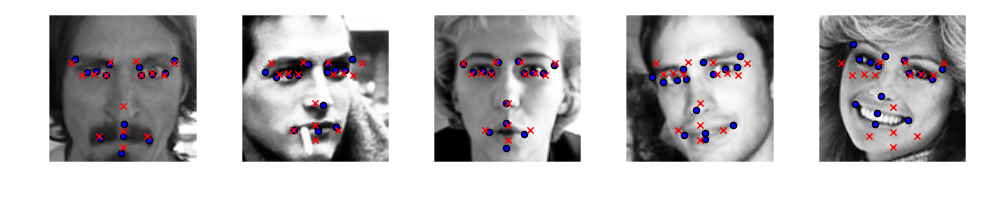

In [23]:
# Plot predictions from dev data
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)

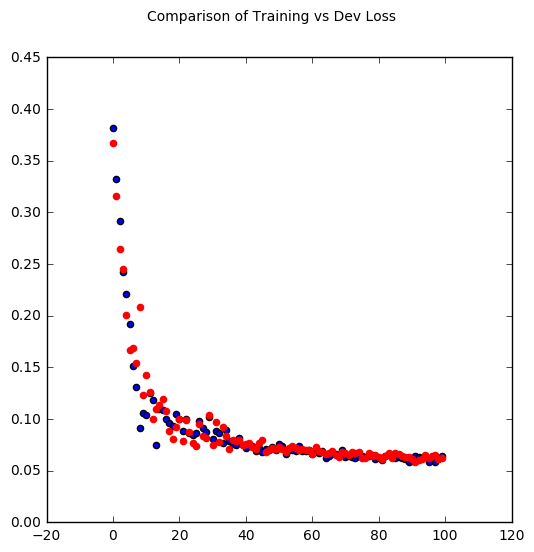

In [24]:

# Plot train/dev errors by epoch
plt.figure(figsize=(6,6))
plt.suptitle("Comparison of Training vs Dev Loss")
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


Adding two additional convolutional layers has not changed the test/dev loss significantly

In [14]:
# Try 2 convolutional layers, 2 fully connected layers

mini_batch_size=400
epochs = 400


# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])


# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters

# Same as previous exercise, next return a 12*12 image with 128 filters
W_conv2a = weight_variable([5, 5, 64, 128])
b_conv2a = bias_variable([128])
h_conv2a = tf.nn.relu(conv2d(h_pool2, W_conv2a) + b_conv2a)
h_pool2a = max_pool_2x2(h_conv2a) #returns a 12*12 image with 128 filters


# Fully connected layer
W_fc1 = weight_variable([12 * 12 * 128, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2a, [-1, 12*12*128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to prevent overfit
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Fully connected layer
W_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# Prediction function
W_fc3 = weight_variable([1024, 30])
b_fc3 = bias_variable([30])
y = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

# Define RMSE error, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-4).minimize(error)

epoch=[i for i in range(epochs)]

# Track train/dev errors for plotting
train_error = []
dev_error = []

# GPU settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True


with tf.Session(config=config) as sess:
    
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate by batch size
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate acccuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of training data
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.2})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        # Determine accuracy on our dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    #Predictions on train/dev/test for plotting
    #result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =3.421
RMSE for dev set =3.0463
RMSE for Epoch 1 =0.47844
RMSE for dev set =0.469757
RMSE for Epoch 2 =0.433246
RMSE for dev set =0.43229
RMSE for Epoch 3 =0.389641
RMSE for dev set =0.390258
RMSE for Epoch 4 =0.358146
RMSE for dev set =0.359113
RMSE for Epoch 5 =0.323429
RMSE for dev set =0.323667
RMSE for Epoch 6 =0.295053
RMSE for dev set =0.310698
RMSE for Epoch 7 =0.272106
RMSE for dev set =0.27788
RMSE for Epoch 8 =0.247947
RMSE for dev set =0.253394
RMSE for Epoch 9 =0.225173
RMSE for dev set =0.228938
RMSE for Epoch 10 =0.208279
RMSE for dev set =0.208311
RMSE for Epoch 11 =0.192184
RMSE for dev set =0.192919
RMSE for Epoch 12 =0.172414
RMSE for dev set =0.175774
RMSE for Epoch 13 =0.164695
RMSE for dev set =0.163922
RMSE for Epoch 14 =0.154319
RMSE for dev set =0.154573
RMSE for Epoch 15 =0.147396
RMSE for dev set =0.14458
RMSE for Epoch 16 =0.13274
RMSE for dev set =0.139573
RMSE for Epoch 17 =0.131715
RMSE for dev set =0.129829
RMSE for Epoch 18 =0.12907
RMS

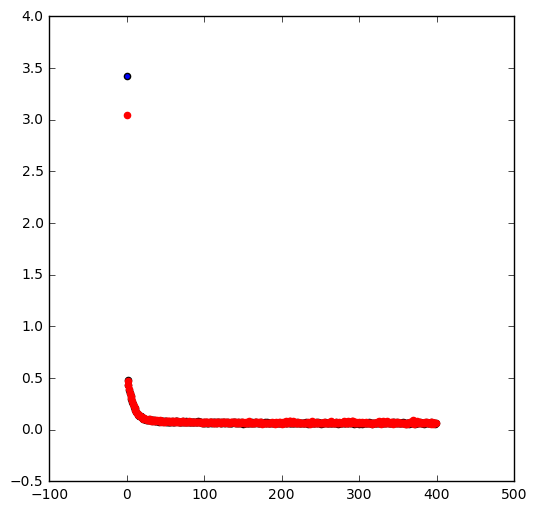

In [15]:
# Plot training and dev errors by epoch
plt.figure(figsize=(6,6))
plt.suptitle("Comparison of Train vs Dev Loss")
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


Adding an additional fully connected layer does not seem to have a huge effect on the training and dev loss. The performance of this model remains comparable to the two models preceding it


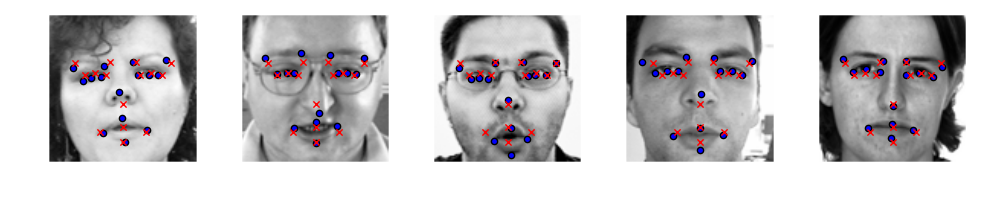

In [16]:
# Plot predicted facial keypoints from dev_data
plot_images(5,dev,result_dev,False) 

In [17]:
# Submission
generate_results(result_test)

| Model 1| Layers                       |  Epochs |   Training Loss  |  Dev Loss  |  Expected RMSE   |
|--------|------------------------------|---------|------------------|------------|------------------|
|   1    | 2 Conv+ReLU+MaxPool, 1 FC    |    300  |    ~.036         |    ~.045   |      2.16        |
|   2    | 4 Conv+ReLU+MaxPool, 1 FC    |    100  |    ~.060         |    ~.060   |      2.88        |
|   3    | 2 Conv+ReLU+MaxPool, 2 FC    |    400  |    ~.060         |    ~.060   |      2.88        ||




**Future Work**
1. Try to use all the available training data by potentially fitting 2 neural nets - one for the 4 keypoints present in all the training data, and one the remaining keypoints
2. Try additional data augmentation techniques to increase the size of the training data. eg. Rotations
